<a href="https://colab.research.google.com/github/jorellano/Crime-Sf/blob/master/21_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading level metrics

Nov 6, 2018

Calculate reading level via coverage on [NGSL](http://www.newgeneralservicelist.org/)


## Setup

In [0]:
import re

import matplotlib.pylab as plt
%config InlineBackend.figure_format = 'retina'

In [0]:
% precision 2

import nltk
nltk.download('book', quiet=True)

True

In [0]:
brown = nltk.corpus.brown

## Flesch-Kincaid


Reuse old syllable counting function

In [0]:
cmudict = nltk.corpus.cmudict.dict()

def stress(pron):
  return [char for phone in pron for char in phone if char.isdigit()]

def syllables(text):
  return sum([w_syllables(w) for w in text if w.isalpha()])

def w_syllables(word):
  word = word.lower()
  if word in cmudict:
    return len(stress(cmudict[word][0]))
  else:
    s = len(re.findall(r'[aeiou]+', word))
    if re.search(r'[aeiou][^aeiou]+e$', word):
      s = s - 1
    return s

Flesch-Kincaid score for a sequence of sentences

$$FK=0.39\times\frac{\text{#words}}{\text{#sents}}+11.8\times\frac{\text{#syllables}}{\text{#words}}-15.59$$

In [0]:
def fk(corpus):
  sents = len(corpus)
  words = len([w for s in corpus for w in s if w.isalpha()])
  sylls = syllables([w for s in corpus for w in s])
  
  return 0.39*(words/sents) + 11.8*(sylls/words) - 15.59

In [0]:
print(f'{"":15} {"FK":>5}')
for cat in brown.categories():
    print(f'{cat:15} {fk(brown.sents(categories=cat)):5.2f}')

                   FK
adventure        4.96
belles_lettres  11.05
editorial        9.92
fiction          5.78
government      12.41
hobbies          9.21
humor            8.37
learned         12.19
lore            10.23
mystery          4.94
news            10.10
religion        10.70
reviews         10.70
romance          5.39
science_fiction  6.33


Grade level for State of the Union addresses, by year

Text(0.5,1,'State of the Union Addresses')

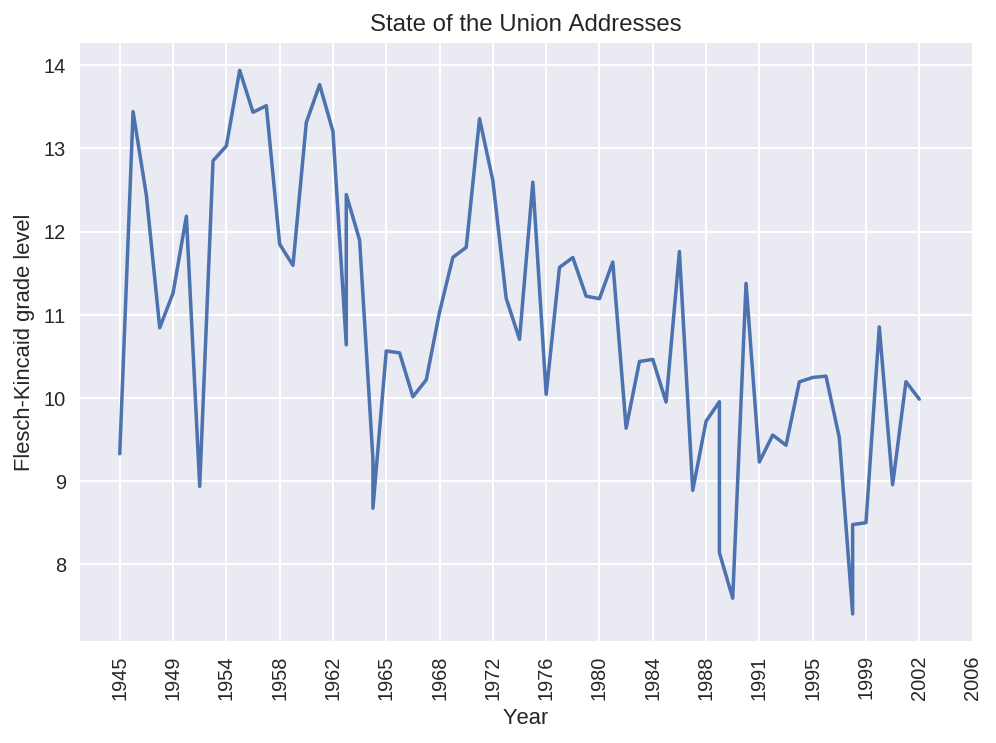

In [0]:
x = [f[0:4] for f in nltk.corpus.state_union.fileids()]
y = [fk(nltk.corpus.state_union.sents(f)) for f in nltk.corpus.state_union.fileids()]
        
  
plt.plot(x, y)
plt.xticks(range(0,len(x),4), x[::4], rotation=90, )   # only label every 4th year
plt.xlabel('Year')
plt.ylabel('Flesch-Kincaid grade level')
plt.title('State of the Union Addresses')

Grade level for inaugural addresses by year

Text(0.5,1,'Inaugural Addresses')

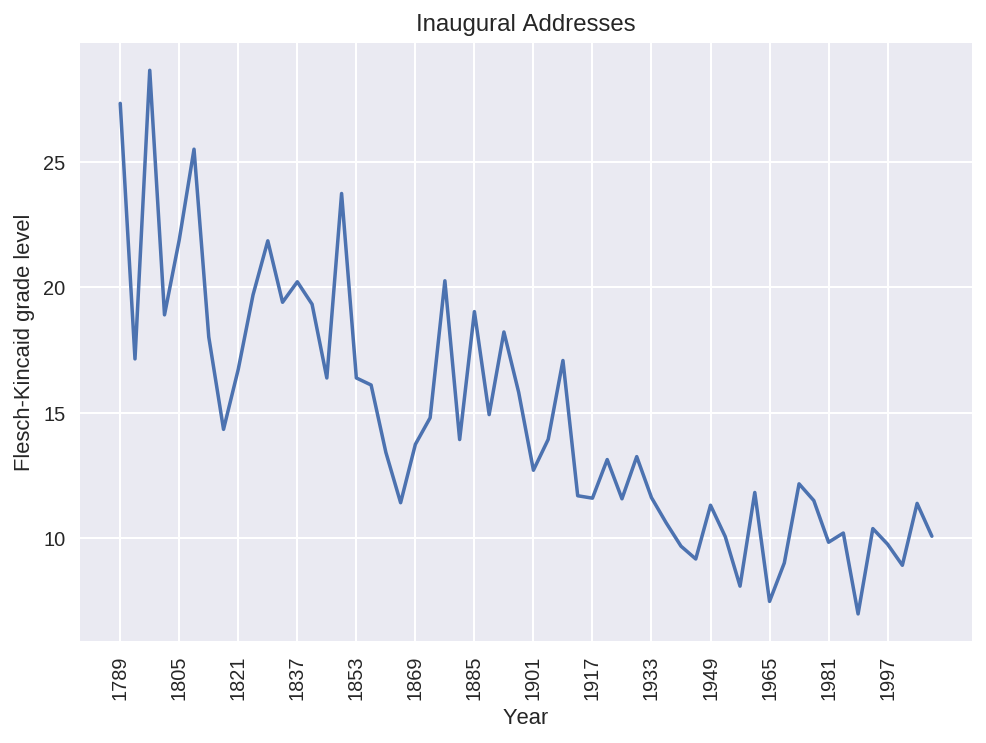

In [0]:
x = [f[0:4] for f in nltk.corpus.inaugural.fileids()]
y = [fk(nltk.corpus.inaugural.sents(f)) for f in nltk.corpus.inaugural.fileids()]

plt.plot(x, y)
plt.xticks(range(0,len(x),4), x[::4], rotation=90)   # only label every 4th year
plt.xlabel('Year')
plt.ylabel('Flesch-Kincaid grade level')
plt.title('Inaugural Addresses')

----

## Lexical coverage

Find % of tokens that are on the New General Service List

### Load the NGSL 

In [0]:
!pip install -q openpyxl

from openpyxl import load_workbook


In [0]:
!wget -q http://www.newgeneralservicelist.org/s/NGSL-101-by-band-qq9o.xlsx
  
wb = load_workbook('NGSL-101-by-band-qq9o.xlsx', read_only=True)
ngsl = set(c.value for ws in wb.sheetnames[:3]
                   for r in wb[ws].rows 
                   for c in r 
                   if type(c.value) is str)

In [0]:
!wget -q http://www.newacademicwordlist.org/s/NAWL_Lemmas.csv
  
nawl = set(w for r in open('NAWL_Lemmas.csv', encoding='latin1')
             for w in r.strip().split(','))

In [0]:
!wget -q http://www.newgeneralservicelist.org/s/BSL_101_lemmatized_for_research.csv
  
bsl = set(w for r in open('BSL_101_lemmatized_for_research.csv', encoding='latin1')
             if not r.startswith('#') 
            for w in r.strip().split(',')
             if w)


In [0]:
len(ngsl), len(nawl), len(bsl)

(8481, 2604, 5111)

In [0]:
combined = ngsl.union(bsl).union(nawl)

### Tokenizer

Re-tokenize Brown corpus following NGSL assumptions

In [0]:
def retok(words):
  text = ' '.join(words)
  return nltk.regexp_tokenize(text.lower(), r'[a-z0-9]+')

### NGSL coverage in Brown corpus

In [0]:
def cov(words, vocab):
  return len([w for w in words if w in vocab]) / len(words) * 100

Coverage of NGSL

In [0]:
print(f'{"":15} {"COV":>5}')
for cat in brown.categories():
    print(f'{cat:15} {cov(retok(brown.words(categories=cat)), ngsl):5.2f}')

                  COV
adventure       85.01
belles_lettres  83.67
editorial       83.46
fiction         85.18
government      84.64
hobbies         82.86
humor           83.63
learned         82.73
lore            83.25
mystery         87.24
news            78.36
religion        84.12
reviews         79.59
romance         86.97
science_fiction 85.41


Coverage of combined NGSL+NAWL+BSL

In [0]:
print(f'{"":15} {"COV":>5}')
for cat in brown.categories():
    print(f'{cat:15} {cov(retok(brown.words(categories=cat)), combined):5.2f}')

                  COV
adventure       87.00
belles_lettres  87.11
editorial       87.15
fiction         87.06
government      89.44
hobbies         86.60
humor           86.12
learned         87.53
lore            86.66
mystery         88.97
news            81.92
religion        87.70
reviews         82.51
romance         88.59
science_fiction 88.49


### NGSL coverage in SOTU corpus

Text(0.5,1,'State of the Union Addresses')

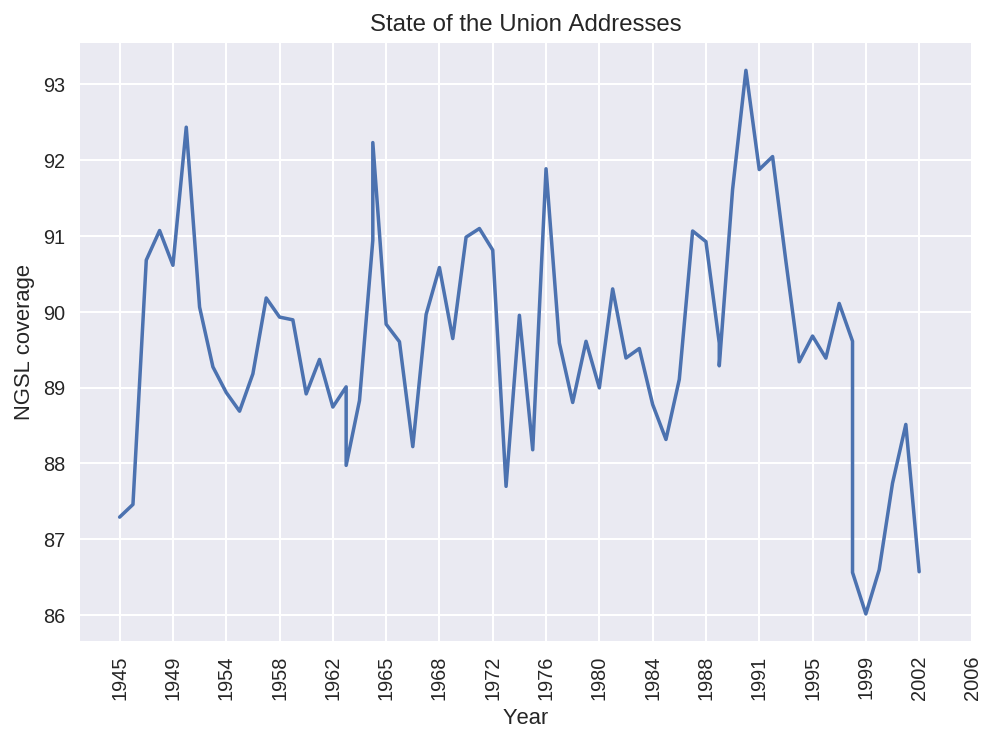

In [0]:
x = [f[0:4] for f in nltk.corpus.state_union.fileids()]
y = [cov(retok(nltk.corpus.state_union.words(f)), ngsl) for f in nltk.corpus.state_union.fileids()]
        
  
plt.plot(x, y)
plt.xticks(range(0,len(x),4), x[::4], rotation=90, )   # only label every 4th year
plt.xlabel('Year')
plt.ylabel('NGSL coverage')
plt.title('State of the Union Addresses')

### NGSL coverage in Inaugural corpus

Text(0.5,1,'State of the Union Addresses')

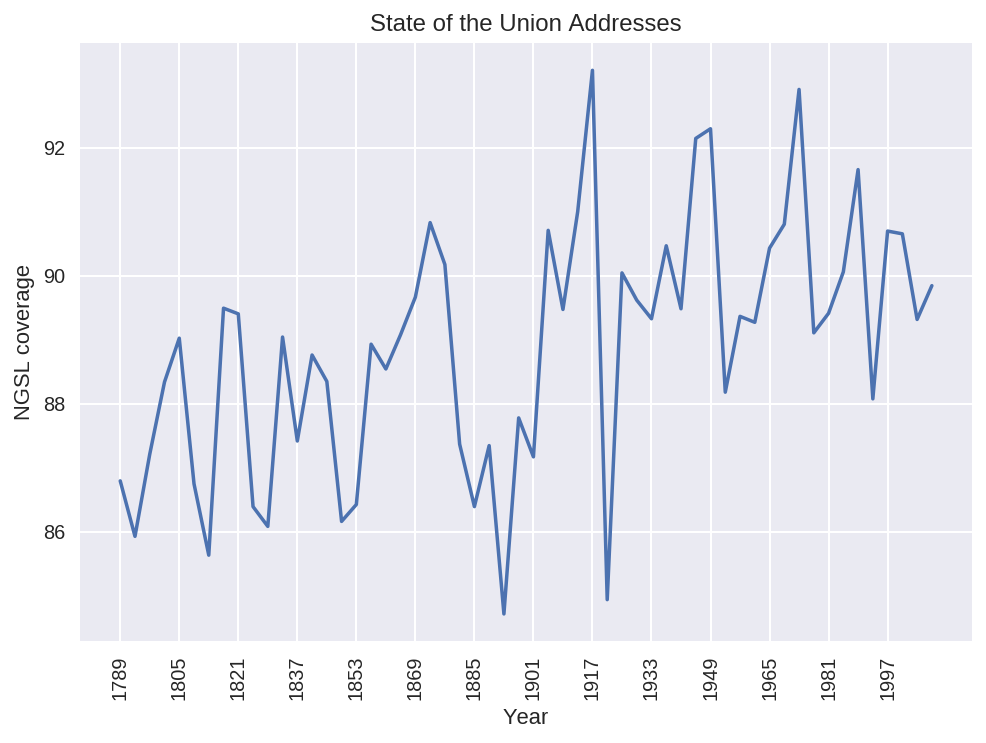

In [0]:
x = [f[0:4] for f in nltk.corpus.inaugural.fileids()]
y = [cov(retok(nltk.corpus.inaugural.words(f)), ngsl) for f in nltk.corpus.inaugural.fileids()]
        
  
plt.plot(x, y)
plt.xticks(range(0,len(x),4), x[::4], rotation=90, )   # only label every 4th year
plt.xlabel('Year')
plt.ylabel('NGSL coverage')
plt.title('State of the Union Addresses')